Loading and preprocessing data...


interactive(children=(Dropdown(description='Geounit:', options=('QTG', 'ECP', 'APG', 'NAO'), value='QTG'), Out…

C:\Users\IWahbi\AppData\Local\Temp\ipykernel_33924\3689855144.py:150: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = merged_data.groupby('Geounit').apply(lambda x: pd.Series({


Correlations by Geounit (Jan 2022 - Jun 2024):
         Tickets_Ops_Revenue_vs_Operating_CellMonth  \
Geounit                                               
NAO                                        0.864977   
ECP                                        0.742234   
QTG                                        0.691392   
APG                                        0.569721   

         CIM_RPE_Ops_Service_Revenue_vs_Operating_CellMonth  \
Geounit                                                       
NAO                                               0.604691    
ECP                                               0.360155    
QTG                                               0.348680    
APG                                               0.586064    

         Tickets_Ops_Revenue_vs_Raw_CellMonth  \
Geounit                                         
NAO                                  0.450132   
ECP                                  0.551508   
QTG                                  0.559509  

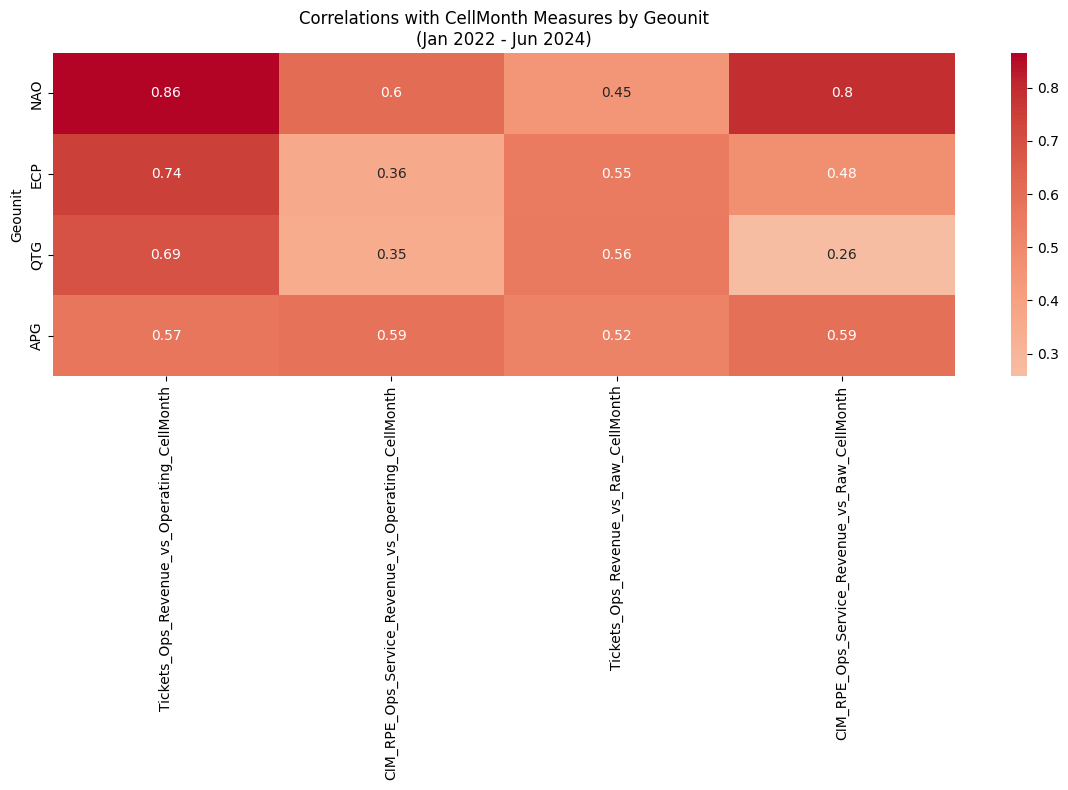

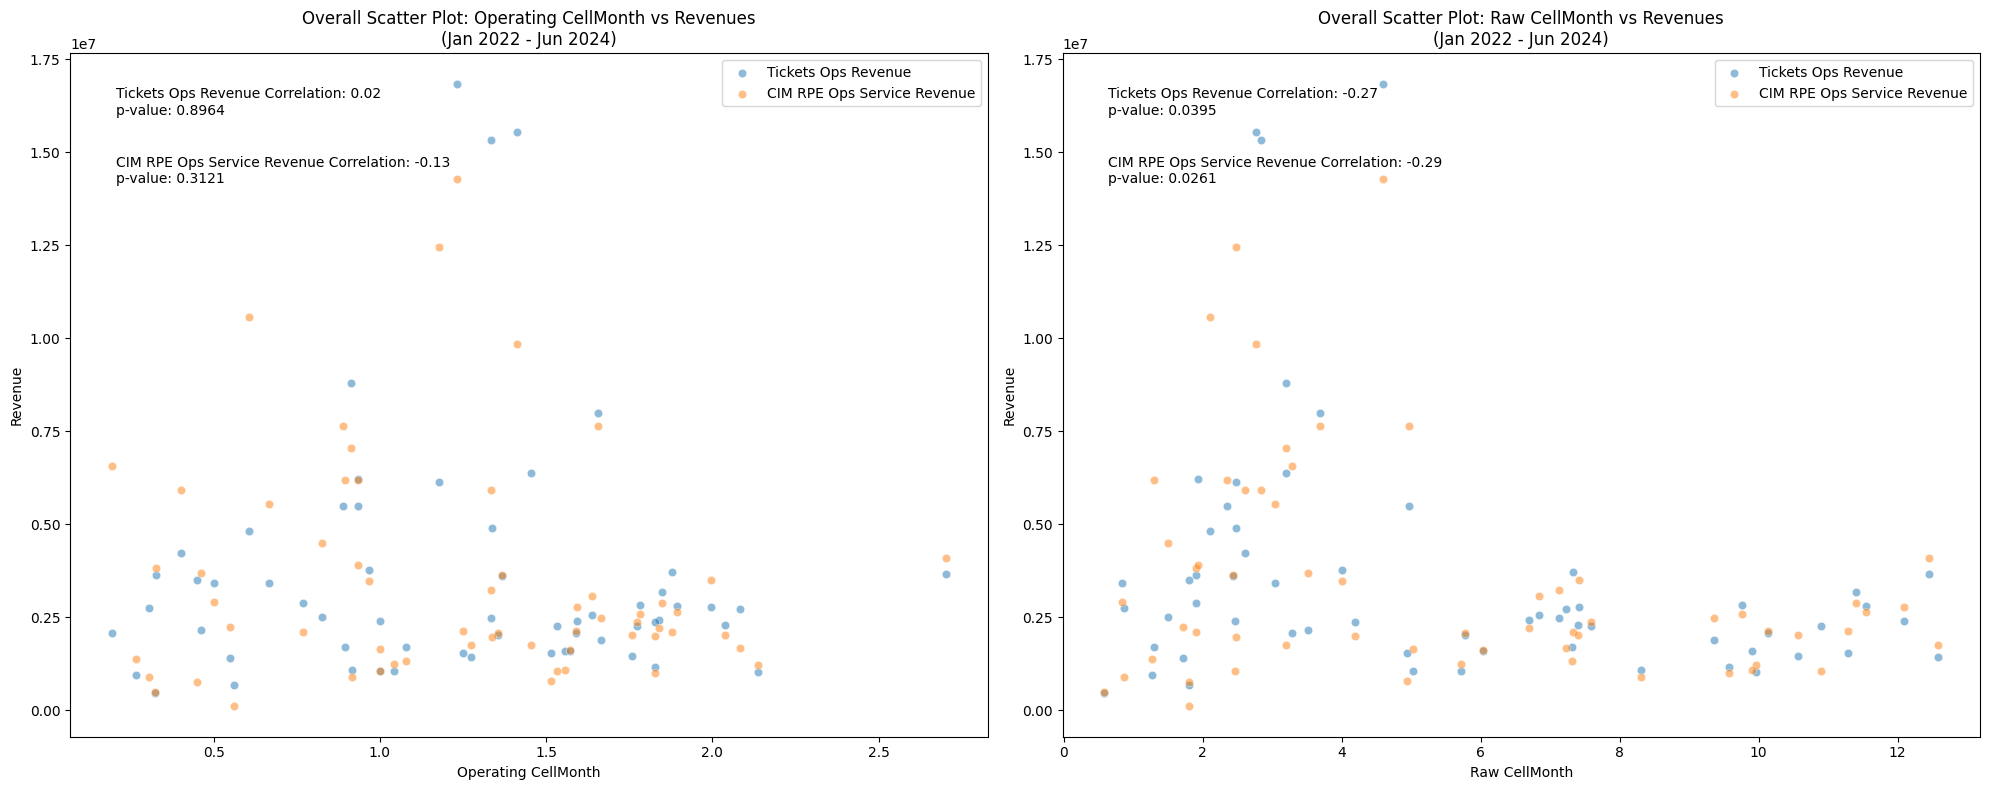

In [2]:
# 06_correlation_analysis.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import ipywidgets as widgets
from ipywidgets import interact

# Load and preprocess the data
print("Loading and preprocessing data...")
tickets_df = pd.read_csv('../processed_data/processed_tickets_wles_ops_data.csv')
rpe_df = pd.read_csv('../raw_data/global_rpe_revenue.csv')
cellmonth_df = pd.read_csv('../raw_data/global_cellmonth_wles_ops_data.csv')

# Preprocess RPE data (assuming you have this function in your utils)
from utils.revenue_data_preprocessing import preprocess_rpe_data
rpe_df = preprocess_rpe_data(rpe_df)

# Convert date columns to datetime
tickets_df['Adjusted Date'] = pd.to_datetime(tickets_df['Adjusted Date'])
rpe_df['Month Date'] = pd.to_datetime(rpe_df['Month Date'])
cellmonth_df['YearMonth'] = pd.to_datetime(cellmonth_df['YearMonth'], format='%Y/%m')

# Define date range
start_date = pd.to_datetime('2023-04-01')
end_date = pd.to_datetime('2024-06-30')

# Filter data for the specified date range
tickets_df = tickets_df[(tickets_df['Adjusted Date'] >= start_date) & (tickets_df['Adjusted Date'] <= end_date)]
rpe_df = rpe_df[(rpe_df['Month Date'] >= start_date) & (rpe_df['Month Date'] <= end_date)]
cellmonth_df = cellmonth_df[(cellmonth_df['YearMonth'] >= start_date) & (cellmonth_df['YearMonth'] <= end_date)]

# Filter for specific geounits (you can modify this list as needed)
geounits_to_include = ['QTG', 'ECP', 'APG', 'NAO']

tickets_df = tickets_df[tickets_df['Sl Geounit (Code)'].isin(geounits_to_include)]
rpe_df = rpe_df[rpe_df['SL Geounit (Code)'].isin(geounits_to_include)]
cellmonth_df = cellmonth_df[cellmonth_df['Geounit'].isin(geounits_to_include)]

# Aggregate tickets data by month and geounit
tickets_monthly = tickets_df.groupby(['Sl Geounit (Code)', pd.Grouper(key='Adjusted Date', freq='MS')])[['Tickets_Revenue', 'Operating_CellMonth']].sum().reset_index()
tickets_monthly.columns = ['Geounit', 'Date', 'Tickets_Ops_Revenue', 'Operating_CellMonth']

# Aggregate RPE data by month and geounit
rpe_monthly = rpe_df.groupby(['SL Geounit (Code)', pd.Grouper(key='Month Date', freq='MS')])['RPE Revenue'].sum().reset_index()
rpe_monthly.columns = ['Geounit', 'Date', 'CIM_RPE_Ops_Service_Revenue']

# Aggregate CellMonth data by month and geounit
cellmonth_monthly = cellmonth_df.groupby(['Geounit', 'YearMonth'])['CellMonth'].sum().reset_index()
cellmonth_monthly.columns = ['Geounit', 'Date', 'CellMonth']

# Merge the datasets
merged_data = pd.merge(tickets_monthly, rpe_monthly, on=['Geounit', 'Date'], how='outer')
merged_data = pd.merge(merged_data, cellmonth_monthly, on=['Geounit', 'Date'], how='outer').fillna(0)

# Add quarter column
merged_data['Quarter'] = merged_data['Date'].dt.to_period('Q')

def plot_geounit_analysis(geounit):
    data = merged_data[merged_data['Geounit'] == geounit]
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 30))
    
    # Scatter plots
    sns.scatterplot(data=data, x='Operating_CellMonth', y='Tickets_Ops_Revenue', ax=axes[0, 0], label='Tickets Ops Revenue')
    sns.scatterplot(data=data, x='Operating_CellMonth', y='CIM_RPE_Ops_Service_Revenue', ax=axes[0, 0], label='CIM RPE Ops Service Revenue')
    axes[0, 0].set_title(f'Scatter Plot: Operating CellMonth vs Revenues - {geounit}\n(Jan 2022 - Jun 2024)')
    axes[0, 0].set_xlabel('Operating CellMonth')
    axes[0, 0].set_ylabel('Revenue')
    axes[0, 0].legend()
    
    sns.scatterplot(data=data, x='CellMonth', y='Tickets_Ops_Revenue', ax=axes[0, 1], label='Tickets Ops Revenue')
    sns.scatterplot(data=data, x='CellMonth', y='CIM_RPE_Ops_Service_Revenue', ax=axes[0, 1], label='CIM RPE Ops Service Revenue')
    axes[0, 1].set_title(f'Scatter Plot: Raw CellMonth vs Revenues - {geounit}\n(Jan 2022 - Jun 2024)')
    axes[0, 1].set_xlabel('Raw CellMonth')
    axes[0, 1].set_ylabel('Revenue')
    axes[0, 1].legend()
    
    # Add correlation coefficients and p-values
    for ax, x_var in zip(axes[0], ['Operating_CellMonth', 'CellMonth']):
        corr1, p_value1 = stats.pearsonr(data[x_var], data['Tickets_Ops_Revenue'])
        corr2, p_value2 = stats.pearsonr(data[x_var], data['CIM_RPE_Ops_Service_Revenue'])
        ax.annotate(f'Tickets Ops Revenue Correlation: {corr1:.2f}\np-value: {p_value1:.4f}', 
                    xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
        ax.annotate(f'CIM RPE Ops Service Revenue Correlation: {corr2:.2f}\np-value: {p_value2:.4f}', 
                    xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='top')
    
    # Monthly time series plots
    for ax, cellmonth_var, title in zip(axes[1], ['Operating_CellMonth', 'CellMonth'], 
                                        ['Operating CellMonth', 'Raw CellMonth']):
        ax.plot(data['Date'], data[cellmonth_var], label=title, color='tab:blue')
        ax.set_ylabel(title, color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')
        ax.legend(loc='upper left')
        
        ax_twin = ax.twinx()
        ax_twin.plot(data['Date'], data['Tickets_Ops_Revenue'], color='tab:orange', label='Tickets Ops Revenue')
        ax_twin.plot(data['Date'], data['CIM_RPE_Ops_Service_Revenue'], color='tab:green', label='CIM RPE Ops Service Revenue')
        ax_twin.set_ylabel('Revenue', color='tab:orange')
        ax_twin.tick_params(axis='y', labelcolor='tab:orange')
        
        ax.set_title(f'Monthly Time Series: {title} and Revenues - {geounit}\n(Jan 2022 - Jun 2024)')
        ax.set_xlabel('Date')
        
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax_twin.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Quarterly time series plots
    quarterly_data = data.groupby('Quarter').agg({
        'Operating_CellMonth': 'sum', 
        'CellMonth': 'sum',
        'Tickets_Ops_Revenue': 'sum', 
        'CIM_RPE_Ops_Service_Revenue': 'sum'
    }).reset_index()
    
    for ax, cellmonth_var, title in zip(axes[2], ['Operating_CellMonth', 'CellMonth'], 
                                        ['Operating CellMonth', 'Raw CellMonth']):
        ax.plot(quarterly_data['Quarter'].astype(str), quarterly_data[cellmonth_var], label=title, color='tab:blue')
        ax.set_ylabel(title, color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')
        ax.legend(loc='upper left')
        
        ax_twin = ax.twinx()
        ax_twin.plot(quarterly_data['Quarter'].astype(str), quarterly_data['Tickets_Ops_Revenue'], color='tab:orange', label='Tickets Ops Revenue')
        ax_twin.plot(quarterly_data['Quarter'].astype(str), quarterly_data['CIM_RPE_Ops_Service_Revenue'], color='tab:green', label='CIM RPE Ops Service Revenue')
        ax_twin.set_ylabel('Revenue', color='tab:orange')
        ax_twin.tick_params(axis='y', labelcolor='tab:orange')
        
        ax.set_title(f'Quarterly Time Series: {title} and Revenues - {geounit}\n(Jan 2022 - Jun 2024)')
        ax.set_xlabel('Quarter')
        ax.set_xticklabels(quarterly_data['Quarter'].astype(str), rotation=45)
        
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax_twin.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(plot_geounit_analysis, geounit=widgets.Dropdown(options=geounits_to_include, description='Geounit:'))

# Calculate correlations for each geounit
correlations = merged_data.groupby('Geounit').apply(lambda x: pd.Series({
    'Tickets_Ops_Revenue_vs_Operating_CellMonth': x['Tickets_Ops_Revenue'].corr(x['Operating_CellMonth']),
    'CIM_RPE_Ops_Service_Revenue_vs_Operating_CellMonth': x['CIM_RPE_Ops_Service_Revenue'].corr(x['Operating_CellMonth']),
    'Tickets_Ops_Revenue_vs_Raw_CellMonth': x['Tickets_Ops_Revenue'].corr(x['CellMonth']),
    'CIM_RPE_Ops_Service_Revenue_vs_Raw_CellMonth': x['CIM_RPE_Ops_Service_Revenue'].corr(x['CellMonth'])
})).sort_values('Tickets_Ops_Revenue_vs_Operating_CellMonth', ascending=False)

print("Correlations by Geounit (Jan 2022 - Jun 2024):")
print(correlations)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlations with CellMonth Measures by Geounit\n(Jan 2022 - Jun 2024)')
plt.tight_layout()
plt.show()

# Overall correlation analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(data=merged_data, x='Operating_CellMonth', y='Tickets_Ops_Revenue', alpha=0.5, label='Tickets Ops Revenue', ax=ax1)
sns.scatterplot(data=merged_data, x='Operating_CellMonth', y='CIM_RPE_Ops_Service_Revenue', alpha=0.5, label='CIM RPE Ops Service Revenue', ax=ax1)
ax1.set_title('Overall Scatter Plot: Operating CellMonth vs Revenues\n(Jan 2022 - Jun 2024)')
ax1.set_xlabel('Operating CellMonth')
ax1.set_ylabel('Revenue')
ax1.legend()

sns.scatterplot(data=merged_data, x='CellMonth', y='Tickets_Ops_Revenue', alpha=0.5, label='Tickets Ops Revenue', ax=ax2)
sns.scatterplot(data=merged_data, x='CellMonth', y='CIM_RPE_Ops_Service_Revenue', alpha=0.5, label='CIM RPE Ops Service Revenue', ax=ax2)
ax2.set_title('Overall Scatter Plot: Raw CellMonth vs Revenues\n(Jan 2022 - Jun 2024)')
ax2.set_xlabel('Raw CellMonth')
ax2.set_ylabel('Revenue')
ax2.legend()

# Add overall correlation coefficients and p-values
for ax, x_var in zip([ax1, ax2], ['Operating_CellMonth', 'CellMonth']):
    corr1, p_value1 = stats.pearsonr(merged_data[x_var], merged_data['Tickets_Ops_Revenue'])
    corr2, p_value2 = stats.pearsonr(merged_data[x_var], merged_data['CIM_RPE_Ops_Service_Revenue'])
    ax.annotate(f'Tickets Ops Revenue Correlation: {corr1:.2f}\np-value: {p_value1:.4f}', 
                xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
    ax.annotate(f'CIM RPE Ops Service Revenue Correlation: {corr2:.2f}\np-value: {p_value2:.4f}', 
                xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='top')

plt.tight_layout()
plt.show()